## Tutorial: Balancing speed and detection efficiency

TLS offers several parameters to balance search speed and detection efficiency. The default parameters (when you specify *nothing*) should work in the vast majority of cases. Please [open an issue on Github](https://github.com/hippke/tls/issues/new/choose) if you see room for improvement.

In this tutorial, we examine the effect of tuning these parameters. From the documentation:

- ``duration_grid_step``: *(float, default: 1.1)* Grid step width between subsequent trial durations, so that $${\rm dur}_{n+1}={\rm dur}_n \times {\rm duration\_grid\_step}$$ With the default value of 1.1, each subsequent trial duration is longer by 10%

- ``transit_depth_min``: *(float, default: 10 ppm)* Shallowest transit depth to be fitted. Transit depths down to half the transit_depth_min can be found at reduced sensitivity. A reasonable value should be estimated from the data to balance sensitivity and avoid fitting the noise floor. Overfitting may cause computational requirements larger by a factor of 10. For reference, the shallowest known transit is 11.9 ppm (Kepler-37b, [Barclay et al. 2013](http://adsabs.harvard.edu/abs/2013Natur.494..452B))

- ``oversampling_factor``: *(int, default: 3)* Oversampling of the period grid to avoid that the true period falls in between trial periods and is missed.

- ``T0_fit_margin``: *(float, default: 0.01)* Acceptable error margin of the mid-transit time T0. Unit: fraction of the transit duration (0.01 is 1%). For small datasets (e.g., Kepler K2; generally: <10k datapoints), this can be set to 0 with minor speed penalty (seconds). Then, every single cadence is sampled. In data with many cadences, however, this can take very long and can have negligible benefits. As an example, consider a Kepler LC light curve of 60000 points, with a maximum fractional transit duration $$T14/P=0.12$$ The longest phase-folded transit signal to be tested is then 7200 points long. With Kepler noise, shifting this signal point-by-point is overkill. Shifting by 1% of the transit duration would result in shifts of 72 cadences for this specific signal.

- ``use_threads``: *(int)* Number of parallel threads to be used. A processor like the Intel Core i7-8700K has 6 cores and can run 12 threads in parallel using hyperthreading. Setting use_threads=12 will cause a full load. If no parameter is given, TLS determines the number of available threads and uses the maximum available (in this case: 12).

We will start by examining one of the shallowest transiting planet from Kepler's extended mission, K2-89 b. It  contains a highly irradiated, sub-Earth-sized planet on a one-day orbit around an M dwarf ([Crossfield+ 2016](http://adsabs.harvard.edu/cgi-bin/nph-bib_query?bibcode=2016ApJS..226....7C), 
[Dressing+ 2017](http://adsabs.harvard.edu/cgi-bin/nph-bib_query?bibcode=2017arXiv170307416D)).

We pull the EVEREST photometry [Luger+ 2018](https://ui.adsabs.harvard.edu/#abs/2018AJ....156...99L/abstract) and apply the usual sliding median to detrend stellar variability.

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 216468514.


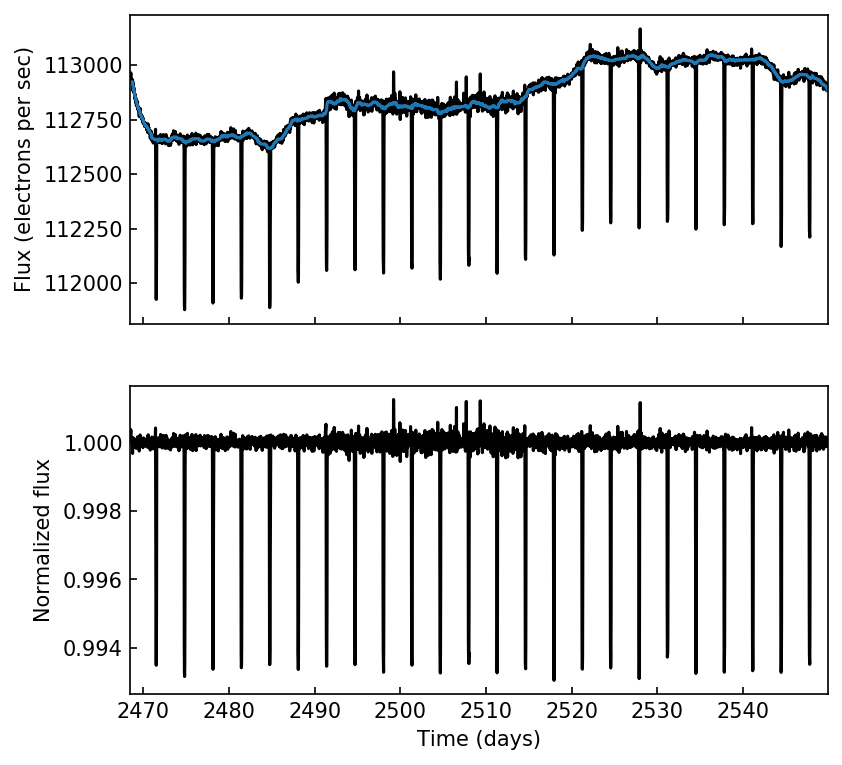

In [27]:
import numpy
import scipy
import everest
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)

from matplotlib import rcParams; rcParams["figure.dpi"] = 150
EPIC_ID = 216468514			#220383386		 #206209135		  # 220250254
star = everest.Everest(EPIC_ID)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')

trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=2, sigma_lower=float('inf'))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("Flux (electrons per sec)")
ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux");

Now, we run TLS with its default parameters, but add limb darkening information from the EPIC catalog.

DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 1367
Transit Least Squares TLS 1.0.15 (25 January 2019)
Creating model cache for 36 durations
Searching 3828 data points, 8657 periods from 0.601 to 40.68 days
Using all 8 CPU threads


100%|██████████| 8657/8657 periods | 00:11<00:00 


Period 3.31318 d
SDE 68.90537 d
Transit duration (hours) 2.64805


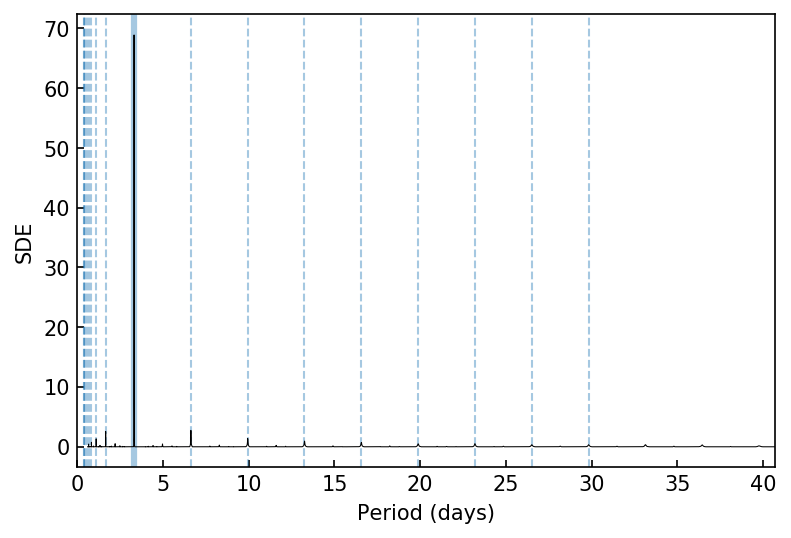

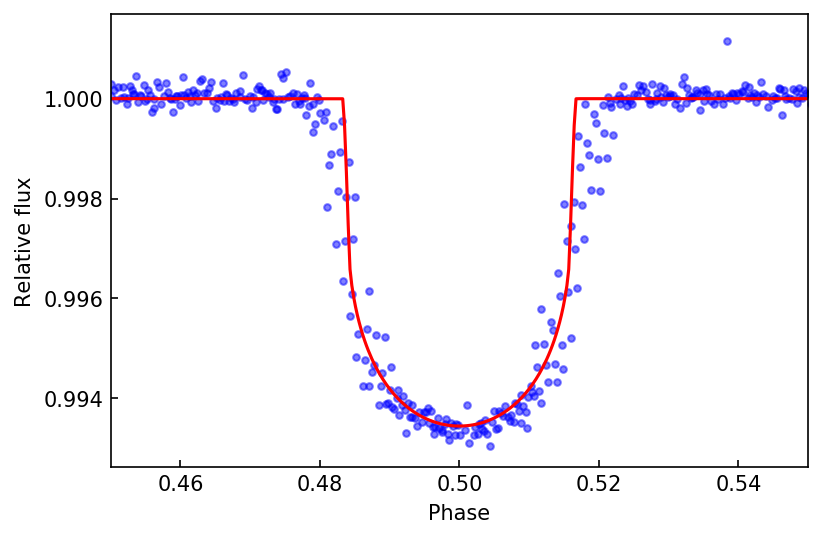

In [28]:
from transitleastsquares import transitleastsquares, catalog_info

ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_ID=EPIC_ID)

model = transitleastsquares(t, y_filt)
results = model.power(u=ab)

print('Period', format(results.period, '.5f'), 'd')
print('SDE', format(results.SDE, '.5f'), 'd')
print('Transit duration (hours)', format(results.duration * 24, '.5f'))

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

Transit Least Squares TLS 1.0.15 (25 January 2019)
Creating model cache for 36 durations
Searching 3828 data points, 28852 periods from 0.602 to 40.68 days
Using all 8 CPU threads


100%|██████████| 28852/28852 periods | 00:35<00:00


Period 3.31395 d
SDE 92.39876 d
Transit duration (hours) 2.64805


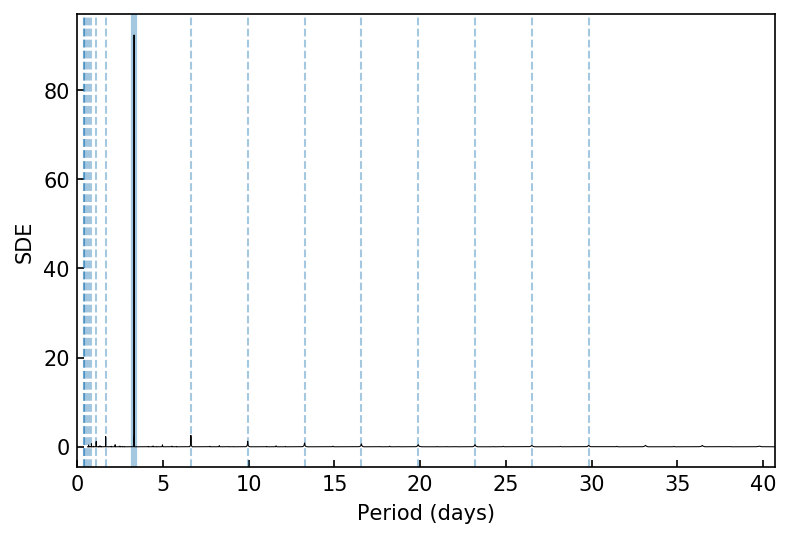

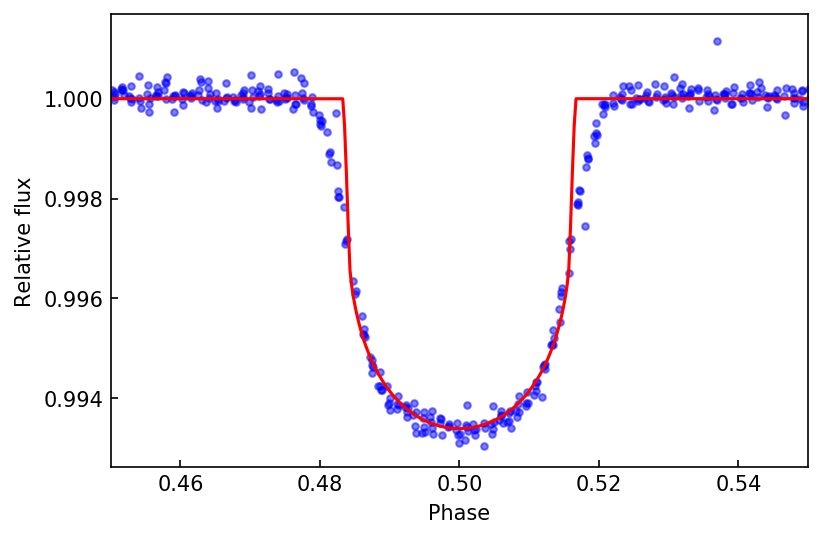

In [29]:
from transitleastsquares import transitleastsquares, catalog_info

ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_ID=EPIC_ID)

model = transitleastsquares(t, y_filt)
results = model.power(u=ab, oversampling_factor=10, duration_step=1.02)

print('Period', format(results.period, '.5f'), 'd')
print('SDE', format(results.SDE, '.5f'), 'd')
print('Transit duration (hours)', format(results.duration * 24, '.5f'))

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.xlabel('Phase')
plt.ylabel('Relative flux');